In [1]:
import os
import glob
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
config = ({"image_size": 512,
           "backbone": "efficientnetb7",
           "method": "unet",
           "class": "outline"
          })

In [4]:
CLASSES = ['building', 'outline']

In [7]:
x_train_dir = './building/train/raw/'
y_train_dir = './building/train/outline_label/'

x_valid_dir = './building/val/raw/'
y_valid_dir = './building/val/outline_label/'

In [8]:
# helper function for data visualizationroads_new_label_val
def visualize(result=False,**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if result:
        plt.savefig(f'./images/{config["class"]}_{config["method"]}_{config["backbone"]}_{config["image_size"]}_{result}.png')
    plt.show()
    
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [9]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fps = glob.glob(images_dir + "*.png")
        self.masks_fps = glob.glob(masks_dir + "*.png")
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values = [149, 255]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [10]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return (batch[0], batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [11]:
import albumentations as A

In [12]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Resize(config['image_size'], config['image_size'])
    ]
    return A.Compose(_transform)

In [13]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [14]:
BACKBONE = config['backbone']
# BATCH_SIZE = config.batch_size
# LR = config.learning_rate
# EPOCHS = config.epochs

preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [16]:
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [17]:
model.load_weights('/home/ssac10/aiffel/hackerton3/models/outline_512.h5')

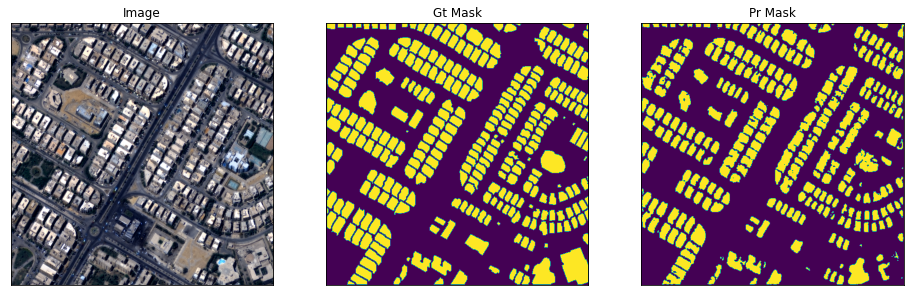

In [25]:
# 127, 8
image, gt_mask = test_dataset[127]
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image).round()

visualize(result='good',
    image=denormalize(image.squeeze()),
    gt_mask=gt_mask[..., 0].squeeze(),
    pr_mask=pr_mask[..., 0].squeeze(),
#         gt_line_mask=gt_mask[..., 1].squeeze(),
#         pr_line_mask=pr_mask[..., 1].squeeze(),
)

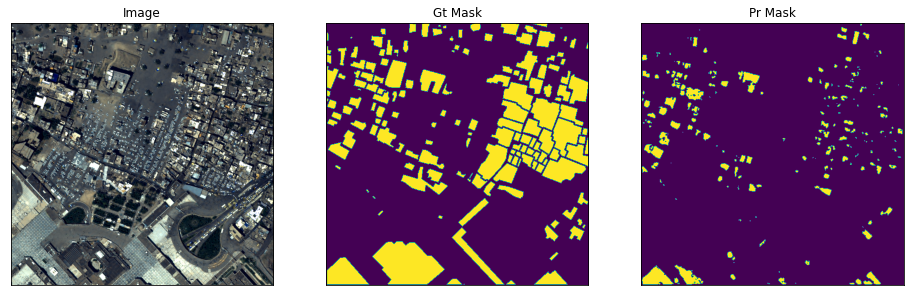

In [21]:
# 127, 8
image, gt_mask = test_dataset[8]
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image).round()

visualize(result='bad',
    image=denormalize(image.squeeze()),
    gt_mask=gt_mask[..., 0].squeeze(),
    pr_mask=pr_mask[..., 0].squeeze(),
#         gt_line_mask=gt_mask[..., 1].squeeze(),
#         pr_line_mask=pr_mask[..., 1].squeeze(),
)

[ 37 129  20  57  21]


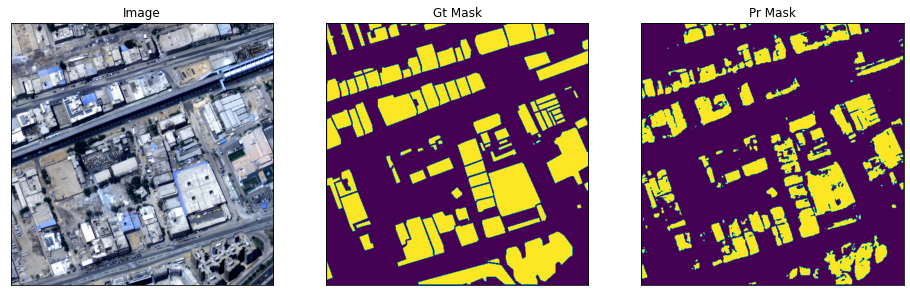

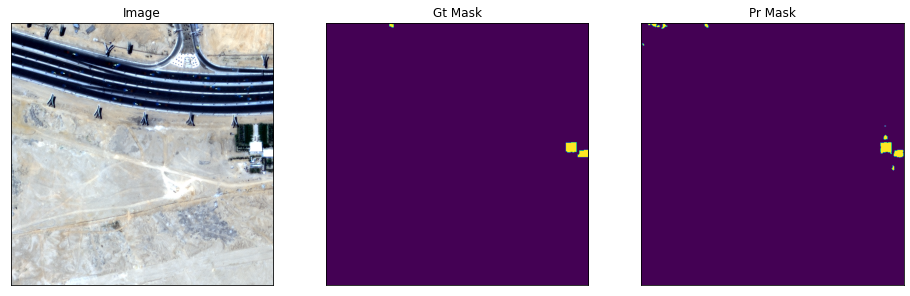

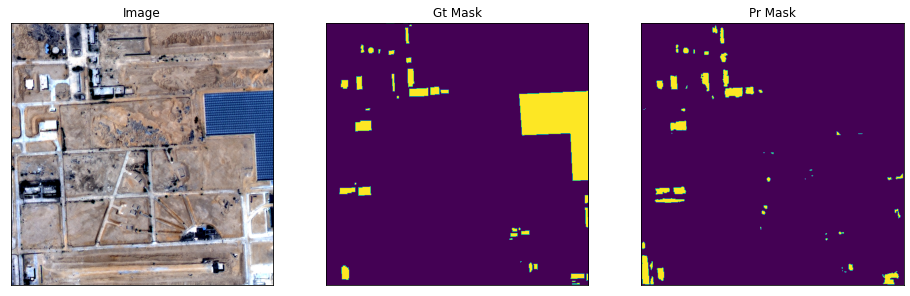

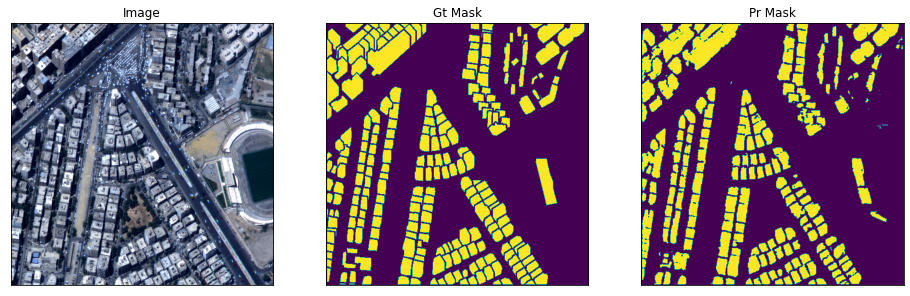

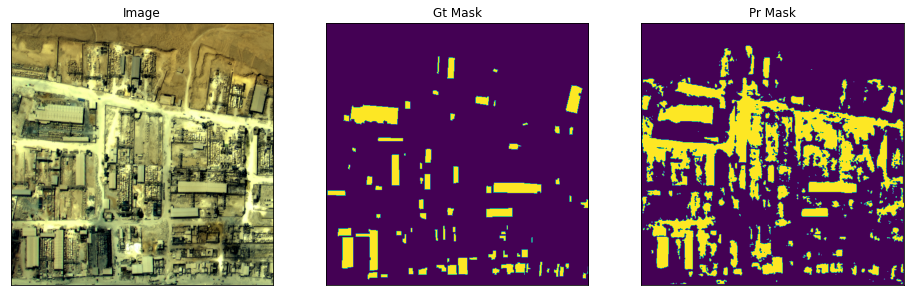

In [24]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
print(ids)

# good 87
# bad 

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
#         gt_line_mask=gt_mask[..., 1].squeeze(),
#         pr_line_mask=pr_mask[..., 1].squeeze(),
    )

In [26]:
pr = pr_mask[..., 0].squeeze()

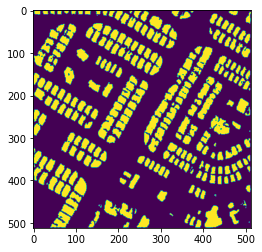

In [27]:
plt.imshow(pr)

In [28]:
pr = (pr * 255).astype(np.uint8)

In [29]:
# 2. opencv 활용해서 물체 탐색
ret, thresh = cv2.threshold(pr, 0, 255, 0)

In [30]:
# get contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [31]:
contours_area = []

In [32]:
# 건물의 개수를 확인 가능 
len(contours)

268

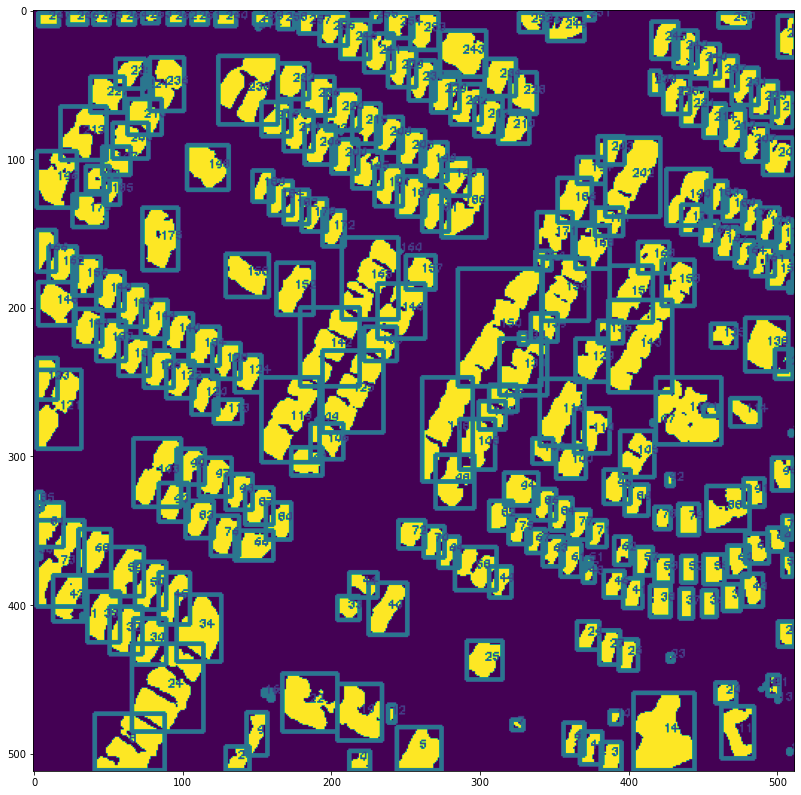

In [33]:
import copy

pr_box = copy.deepcopy(pr)
# pr_box = pr_box * 255
for i in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i])
    cv2.rectangle(pr_box,(x,y),(x+w,y+h),(100),2)
    font=cv2.FONT_HERSHEY_PLAIN 
    point = tuple([int(x+0.5*w), int(y+0.5*h)])
    cv2.putText(pr_box, str(i), point, font, 0.5, (50), 1)
plt.figure(figsize=(14,14))
plt.imshow(pr_box)

In [34]:
# 꼭지점이 3개 미만인 contour를 제거하는 메소드 
def precheck(contours):
    contours_list = []
    num = 0
    for i in contours:
        if len(i) > 3:
            contours_list.append(i)
    result = np.array(contours_list)
    return result   

In [35]:
checked_contours = precheck(contours)

In [36]:
# contours의 길이가 줄어든 것을 통해 지워진 것을 확인 가능 
len(checked_contours)

259

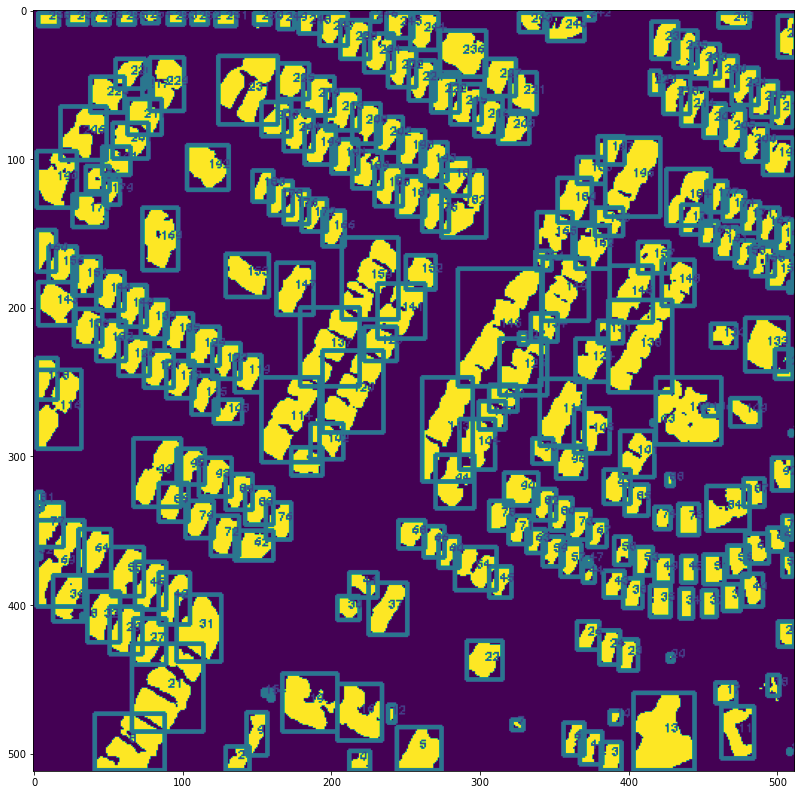

In [37]:
pr_box = copy.deepcopy(pr)
# pr_box = pr_box * 255
for i in range(len(checked_contours)):
    x,y,w,h = cv2.boundingRect(checked_contours[i])
    cv2.rectangle(pr_box,(x,y),(x+w,y+h),(100),2)
    font=cv2.FONT_HERSHEY_PLAIN 
    point = tuple([int(x+0.5*w), int(y+0.5*h)])
    cv2.putText(pr_box, str(i), point, font, 0.5, (50), 1)
plt.figure(figsize=(14,14))
plt.imshow(pr_box)